## Fisher Forecasting Tutorial
In this notebook gives a intro to cosmology fisher forecasting and many codes are based on the tutorial notebook from Zack Li and pycamb \
https://nbviewer.jupyter.org/github/xzackli/fishchips-public/blob/master/notebooks/Introduction%20to%20Fisher%20Forecasting.ipynb \
https://camb.readthedocs.io/en/latest/CAMBdemo.html \
Forecasting for the angular power spectrum $C_l$ of the fluctuations in CMB power spectrum is used as an example in this notebook

In [1]:
# Load necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from numpy.linalg import multi_dot
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Users/zhiyuanguo/opt/anaconda3/envs/Forecasting/lib/python3.9/site-packages/camb


In [2]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2000, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')    
fiducial = powers['total'][:,0]
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

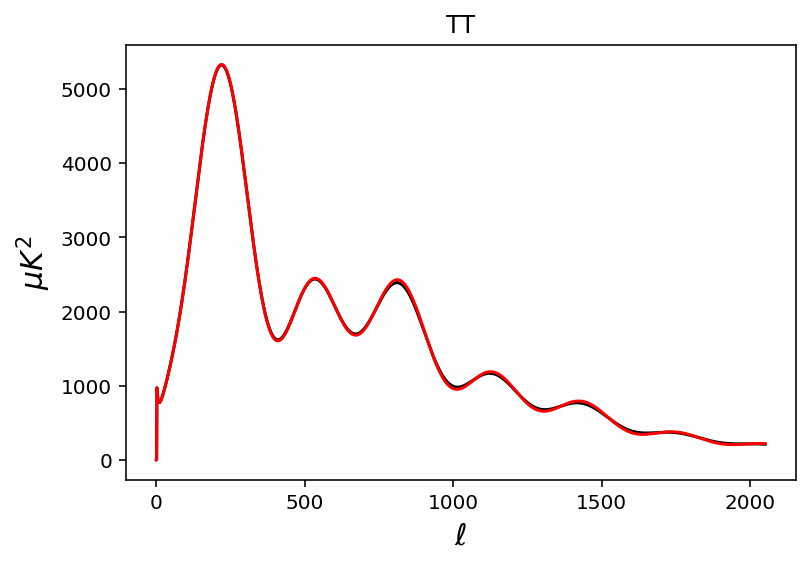

In [3]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(1, figsize = (6,4))
ax.plot(ls,totCL[:,0], color='k')
ax.plot(ls,unlensedCL[:,0], color='r')
ax.set_title('TT')
plt.xlabel(r'$\ell$',fontsize = 15)
plt.ylabel(r'$\mu K^2$',fontsize= 15);

### Calculating derivative $\frac{\partial C_{\ell}^{XY}}{\partial \theta_i}$
with ${\theta_i}$ being the cosmological parameters, ${XY}$ represents $TT,TE,EE$ power spectrum

/var/folders/51/9q0zjh4136519xgt69npnbsm0000gn/T/ipykernel_22251/3883050806.py:31: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( dCltt_dh / fiducial )


(0.0, 2000.0)

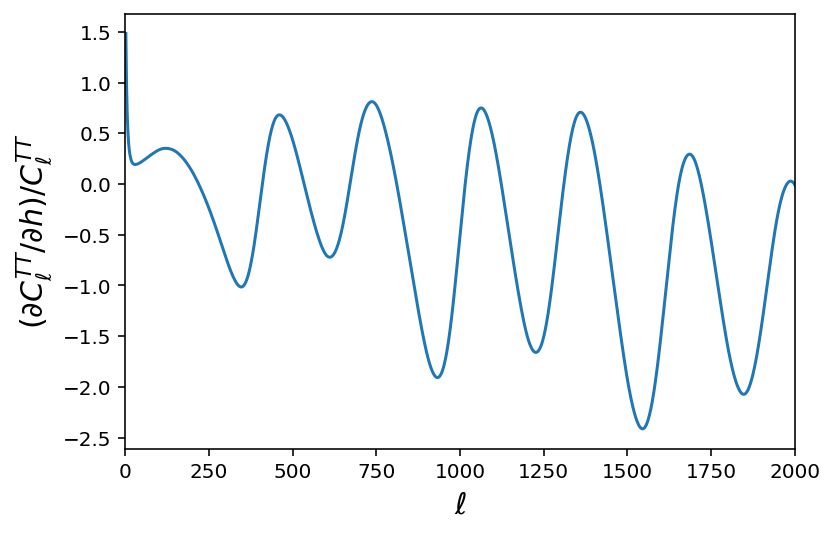

In [4]:
# Function calls camb to run simulation
def utility_func_camb (Input,channel):
    
    camb.get_results(Input)
    powers =results.get_cmb_power_spectra(Input, CMB_unit='muK')
    totCL=powers['total']
    return(totCL[:,channel])


# Function calculating the derivative for a given power spectrum 
# and given cosmological paraemters with specified step size for taking the derivative
# A general rule of thumb for step size is about ~1% of the fudicial value according to Zack Li's tutorial
def get_deriv(parms = pars,par_name = 'h',channel = 'tt',step_size = 0.01):
    if channel == 'tt':
        index = 0
    elif channel == 'ee':
        index = 1
    elif channel == 'te':
        index = 3
    left_params = parms.copy()
    setattr(left_params,par_name,getattr(parms,par_name)-step_size)
    right_params = pars.copy()
    setattr(right_params,par_name,getattr(parms,par_name)+step_size)

    left = utility_func_camb(Input=left_params,channel=index)
    right = utility_func_camb(Input=right_params,channel=index)
    dCl_dh = (right-left)/(2 * step_size)   
    return(dCl_dh)

dCltt_dh = get_deriv(par_name='h',channel = 'tt',step_size=0.001)
plt.plot( dCltt_dh / fiducial )
plt.ylabel(r'$(\partial C_{\ell}^{TT} / \partial h) / C_{\ell}^{TT}$',fontsize =15)
plt.xlabel(r'$\ell$',fontsize = 15);
plt.xlim(0,2000)

### Fisher Matrix calculation for three parameters: $\Omega_{CDM}h^2$, $\Omega_{b}h^2$ and $h$
Fisher Matrix for CMB power spectrum:\
$F_{ij} = \sum_{\ell}\frac{2l+1}{2}f_{sky}Tr\left(C_{\ell}^{-1}\frac{\partial C_{\ell}}
    {\partial \theta_i}C_{\ell}^{-1}\frac{\partial C_{\ell}}{\partial \theta_j}\right)$

In [5]:
from numpy.linalg import inv


def get_cl_inverse (index):
    '''
    Function give the inverse Cl matrix for a given multipole l
    '''
    
    # Noise component in Fisher matrix, see https://arxiv.org/pdf/1806.10165.pdf
    sT = 33 * (np.pi/60./180.)
    sP = sT * np.sqrt(2.)
    theta_FWHM = 7. * (np.pi/60./180.)
    Noise = sT**2*np.exp(index*(index+1)*theta_FWHM**2/(8*np.log(2)))*1e6
    
    # Assign Cl values 
    Cl_TT = totCL[:,0][index]
    Cl_EE = totCL[:,1][index]
    Cl_TE = totCL[:,3][index]
    Cl_mat = np.empty(shape = (2,2))
    Cl_mat[0,0] = Cl_TT + Noise
    Cl_mat[1,1] = Cl_EE + 2*Noise
    Cl_mat[0,1] = Cl_mat[1,0] = Cl_TE
    
    # Taking the inverse
    Cl_mat_inv = inv(Cl_mat)
    return(Cl_mat_inv)
    
def form_2x2_matrix(diag1,diag2,offdiag):
    '''
    Function return a 2x2 matrix
    '''
    M = np.empty(shape = (2,2))
    M[0,0] = diag1
    M[1,1] = diag2
    M[0,1] = M[1,0] = offdiag
    return(M)

In [6]:
#Calculate Fisher Matrix
Fisher_M = np.zeros(shape = (3,3))

# Fraction of the sky covered by the experiment
f_sky = 0.6

# Calculating the derivative
dCl_tt_h = get_deriv(par_name='h',channel = 'tt',step_size=0.01)
dCl_ee_h = get_deriv(par_name='h',channel = 'ee',step_size=0.01)
dCl_te_h = get_deriv(par_name='h',channel = 'te',step_size=0.01)


dCl_tt_omgbh2 = get_deriv(par_name='ombh2',channel = 'tt',step_size=0.001)
dCl_ee_omgbh2 = get_deriv(par_name='ombh2',channel = 'ee',step_size=0.001)
dCl_te_omgbh2 = get_deriv(par_name='ombh2',channel = 'te',step_size=0.001)


dCl_tt_omgch2 = get_deriv(par_name='omch2',channel = 'tt',step_size=0.001)
dCl_ee_omgch2 = get_deriv(par_name='omch2',channel = 'ee',step_size=0.001)
dCl_te_omgch2 = get_deriv(par_name='omch2',channel = 'te',step_size=0.001)

In [7]:
# Sum up to l = 2000, discard monopole and diapole moments
for k in range(1998):
    i = k + 2
    M_dCl_h = form_2x2_matrix(diag1=dCl_tt_h[i],diag2=dCl_ee_h[i],offdiag=dCl_te_h[i])
    
    M_dCl_omgbh2 = form_2x2_matrix(diag1=dCl_tt_omgbh2[i],diag2=dCl_ee_omgbh2[i],offdiag=dCl_te_omgbh2[i])
    
    M_dCl_omgch2 = form_2x2_matrix(diag1=dCl_tt_omgch2[i],diag2=dCl_ee_omgch2[i],offdiag=dCl_te_omgch2[i])
    
    Cl_inv = get_cl_inverse(index=i)
    
    Fisher_M[1,1] += (2*i+1)/2 * f_sky * np.trace(multi_dot([Cl_inv,M_dCl_omgbh2,Cl_inv,M_dCl_omgbh2]))
    Fisher_M[2,2] += (2*i+1)/2 * f_sky * np.trace(multi_dot([Cl_inv,M_dCl_h,Cl_inv,M_dCl_h]))
    Fisher_M[0,0] += (2*i+1)/2 * f_sky * np.trace(multi_dot([Cl_inv,M_dCl_omgch2,Cl_inv,M_dCl_omgch2]))
    Fisher_M[0,1] += (2*i+1)/2 * f_sky * np.trace(multi_dot([Cl_inv,M_dCl_omgch2,Cl_inv,M_dCl_omgbh2]))
    Fisher_M[0,2] += (2*i+1)/2 * f_sky * np.trace(multi_dot([Cl_inv,M_dCl_omgch2,Cl_inv,M_dCl_h]))
    Fisher_M[1,2] += (2*i+1)/2 * f_sky * np.trace(multi_dot([Cl_inv,M_dCl_omgbh2,Cl_inv,M_dCl_h]))

Fisher_M[1,0] = Fisher_M[0,1]
Fisher_M[2,0] = Fisher_M[0,2]
Fisher_M[2,1] = Fisher_M[1,2]

Covariance matrix: $Cov = F^{-1}$\
marginalized constrain: $\sigma_I = \sqrt{Cov_{ii}}$

### Plot the contour

In [8]:
# Get the Convariance matrix from Fisher matrix
Cov = inv(Fisher_M)


# Set up the parameters for plotting
# https://arxiv.org/pdf/0906.4123.pdf has a nice description on drawing contours
ALPHA1 = 1.52
ALPHA2 = 2.48
sigma_x2 = Cov[0,0]
sigma_y2 = Cov[1,1]
sigma_xy = Cov[0,1]
a2 = (sigma_x2+sigma_y2)/2. + np.sqrt((sigma_x2 - sigma_y2)**2/4. + sigma_xy**2)
b2 = (sigma_x2+sigma_y2)/2. - np.sqrt((sigma_x2 - sigma_y2)**2/4. + sigma_xy**2)
sigma_x = np.sqrt(sigma_x2)
sigma_y = np.sqrt(sigma_y2)
angle = np.arctan(2.*sigma_xy/(sigma_x2-sigma_y2)) /2 
a = np.sqrt(a2)
b = np.sqrt(b2)
theta = angle * 180.0 / np.pi

Text(0, 0.5, '$\\Omega_{b}h^2$')

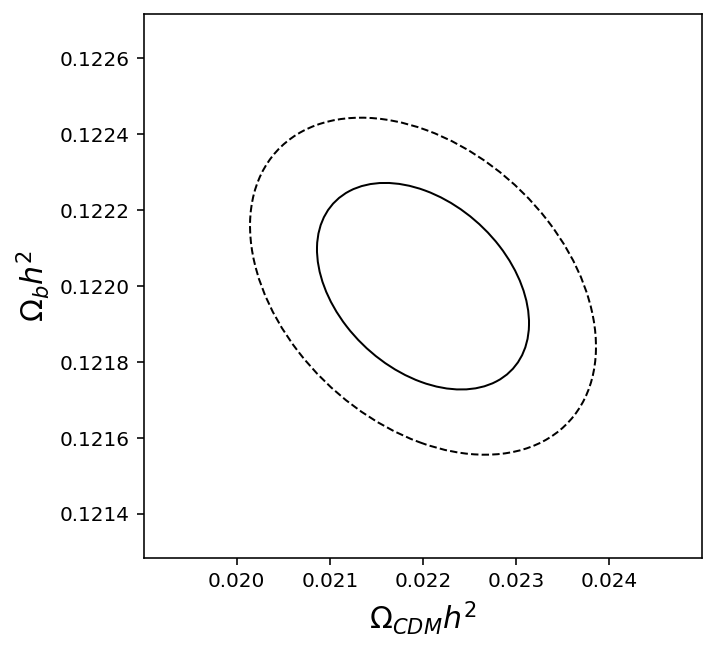

In [9]:
PLOT_MULT = 4.

# 2-sigma ellipse
fig,ax = plt.subplots(1,figsize = (5,5))
e1 = Ellipse(
    xy=(pars.ombh2, pars.omch2),
    width=a * 2 * ALPHA2, height=b * 2 * ALPHA2,
    angle=theta,ls = '--',fill = False)
ax.add_artist(e1)
e1.set_clip_box(ax.bbox)

# 1-sigma ellipse
e2 = Ellipse(
    xy=(pars.ombh2, pars.omch2),
    width=a * 2 * ALPHA1, height=b * 2 * ALPHA1,
    angle=theta,fill = False)
ax.add_artist(e2)

e2.set_clip_box(ax.bbox)

ax.set_ylim(max(0.0, pars.omch2-PLOT_MULT*sigma_y),pars.omch2+PLOT_MULT*sigma_y)
ax.set_xlim(max(0.0, pars.ombh2-PLOT_MULT*sigma_x),pars.ombh2+PLOT_MULT*sigma_x)
ax.set_xlabel(r'$\Omega_{CDM}h^2$',fontsize = 15)
ax.set_ylabel(r'$\Omega_{b}h^2$',fontsize = 15)